### Import Libraries
Can adjust as needed.

In [1]:
import os
import time
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from cycler import cycler

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import font_manager as fm
from matplotlib.ticker import (
    MultipleLocator, FormatStrFormatter, AutoMinorLocator, FuncFormatter)

from PIL import ImageFont, ImageDraw, Image 
from IPython.display import display
from IPython.display import Image as im

import io
from collections import Counter 

import plotly.graph_objects as go

import datetime
from datetime import datetime as dt
%matplotlib inline

### Import Data
Imports both text files to pandas dataframes.

In [2]:
raw_orig = pd.read_csv('Data\Raw_Data.txt', skiprows=3)
class_orig = pd.read_csv('Data\Classified_Events.txt')

### Useful Arrays and Functions

Create arrays and lists for labels in data, index headers for grouped data, and color palettes.

In [3]:
# Creates array of unique labels in classified data
Labels_orig = class_orig.Label.unique()

# Creates dictionary of labels for plotting different groups of data
labDict = {} 
labDict['All'] = ['faucet','toilet','hose','clothwasher','shower','irrigation','unclassified']
labDict['Indoor'] = ['faucet','toilet','clothwasher','shower']
labDict['Outdoor'] = ['hose','irrigation']
labDict['No_Unclassified'] = ['faucet','toilet','hose','clothwasher','shower','irrigation']
labDict['No_Irrigation'] = ['faucet','toilet','hose','clothwasher','shower','unclassified']
labDict['No_Irrigation_Unclassified'] = ['faucet','toilet','hose','clothwasher','shower']

# List used for headers for grouped data later
Index_Order = ['Label', 'Year', 'Month', 'Week', 'Day']

# Color palettes for design (number corresponds to quantity of colors)
Pal_1 = ['#5EBCD2']
Pal_2 = ['#85CBCF', '#3984B6']
Pal_3 = ['#85CBCF', '#3984B6', '#1D2E81']
Pal_4 = ['#9ED5CD', '#44A7CB', '#2E62A1', '#192574']
Pal_5 = ['#B7DFCB', '#5ABAD1', '#3984B6', '#264992', '#161F63']
Pal_6 = ['#BEE0CC', '#70C3D0', '#419DC5', '#316BA7', '#223B89', '#151E5E']
Pal_7 = ['#C6E3CB', '#83CACF', '#47AED0', '#3984B6', '#2C5A9C', '#1E3082', '#141C59']
Pal_8 = ['#CEE6CA', '#91D0CE', '#56B9D2', '#3F97C2', '#3371AA', '#274B93', '#1B277C', '#131A55']
Pal_9 = ['#D5E9CA', '#9ED5CD', '#69C0D1', '#44A7CB', '#3984B6', '#2E62A1', '#223E8C', '#192473', '#121850']
Pal_10 = ['#DCECC9', '#AADACC', '#78C6D0', '#48B3D3', '#3E94C0', '#3474AC', '#2A5599', '#203686', '#18216B', '#11174B']
Pal_11 = ['#DCECC9', '#AFDCCC', '#83CACF', '#56B9D2', '#43A1C7', '#3984B6', '#3067A5', '#274B93', '#1E3082', '#172068', '#11174B']
Pal_12 = ['#DCECC9', '#B3DDCC', '#8ACDCE', '#62BED2', '#46AACE', '#3D91BE', '#3577AE', '#2D5E9E', '#24448E', '#1C2B7F', '#162065', '#11174B']

Functions to find date ranges from year and week number.

In [4]:
def getDateRangeFromWeek(p_year,p_week):
    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
    return firstdayofweek, lastdayofweek

def getFirstDayFromWeek(p_year,p_week):
    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
    return firstdayofweek

def getLastDayFromWeek(p_year,p_week):
    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
    return lastdayofweek

Function for choosing color palette based on number of elements to plot.

In [5]:
# Returns color palette
def color_palette(length):
    if len(length) == 1:
        color_pal = Pal_1
    elif len(length) == 2:
        color_pal = Pal_2
    elif len(length) == 3:
        color_pal = Pal_3
    elif len(length) == 4:
        color_pal = Pal_4
    elif len(length) == 5:
        color_pal = Pal_5
    elif len(length) == 6:
        color_pal = Pal_6
    elif len(length) == 7:
        color_pal = Pal_7
    elif len(length) == 8:
        color_pal = Pal_8
    elif len(length) == 9:
        color_pal = Pal_9
    elif len(length) == 10:
        color_pal = Pal_10
    elif len(length) == 11:
        color_pal = Pal_11
    elif len(length) == 12:
        color_pal = Pal_12
    return color_pal

# Adds color palette to cycler function for matplotlib
def color_palette_cycler(length):
    color_pal = color_palette(length)
    custom_cycler = (cycler(color=color_pal))
    return custom_cycler

### Create Directories for Saving Results

In [6]:
Results = 'Results' #Can change the string to fit the directory of choice
if not os.path.exists(Results):
    os.makedirs(Results)

### Data Cleanup and Number Formatting

Converts time column of raw data to datetime and indexes the dataframe. Also calculates usage from pulses.

In [7]:
# Create column with datetime format and set as index
raw_orig['Time'] = pd.to_datetime(raw_orig['Time'], format='%Y-%m-%d %H:%M:%S')
raw_orig.set_index('Time', inplace=True)
raw_orig.sort_index(inplace=True)

# Finds total date range of measurements from raw data
raw_dates = pd.period_range(min(raw_orig.index), max(raw_orig.index))

# Calculates usage from pulses and add label column
raw_orig['Volume(gal)'] = raw_orig['Pulses']*0.041619
raw_orig['Label'] = 'Total_Raw'

Checks if each classified label has a value per date. If not creates values equal to zero.

In [8]:
# Creates empty dataframe with headers to fill with values of zero on missing dates
class_zero = pd.DataFrame(columns=['StartTime', 'EndTime', 'Duration(min)',
                                   'Volume(gal)', 'Flowrate(gpm)', 'Peak_Value(gpm)', 'Mode_Value(gpm)', 'Label'])

# Finds missing dates and appends to the classified_zero dataframe
for date in raw_dates:
    date = str(date)
    date_label = date + ' 01:00:00'
    for label in Labels_orig:
        length = len(class_orig.loc[(class_orig['StartTime'].str.contains(date)) & (class_orig['Label'] == label)])
        if length > 0:
            pass
        else:
            class_zero.loc[len(class_zero.index)] = [date_label, date_label, 0, 0, 0, 0, 0, label]

# Append dataframe of zeros to original dataframe
classified = pd.concat([class_orig, class_zero])

Converts time columns of each dataframe to datetime format and creates related index.

In [9]:
# Creates datetime formats
classified['StartTime'] = pd.to_datetime(classified['StartTime'], format='%Y-%m-%d %H:%M:%S')
classified['EndTime'] = pd.to_datetime(classified['EndTime'], format='%Y-%m-%d %H:%M:%S')
classified.set_index('StartTime', inplace=True)
classified.sort_index(inplace=True)

### Grouping Values
Groups dataframes by label then date and calculates a running sum of volume of water usage.

In [10]:
# Creates a cumulative sum for different time periods determined by the level
raw_year = raw_orig.groupby(by=['Label',raw_orig.index.year,raw_orig.index.month,raw_orig.index.week,raw_orig.index.day])[['Volume(gal)']].sum().groupby(level=[0,1]).cumsum()
raw_month = raw_orig.groupby(by=['Label',raw_orig.index.year,raw_orig.index.month,raw_orig.index.week,raw_orig.index.day])[['Volume(gal)']].sum().groupby(level=[0,2]).cumsum()
raw_week = raw_orig.groupby(by=['Label',raw_orig.index.year,raw_orig.index.month,raw_orig.index.week,raw_orig.index.day])[['Volume(gal)']].sum().groupby(level=[0,3]).cumsum()
raw_day = raw_orig.groupby(by=['Label',raw_orig.index.year,raw_orig.index.month,raw_orig.index.week,raw_orig.index.day])[['Volume(gal)']].sum().groupby(level=[0,4]).cumsum()

# Creates an empty data frame to store all cumulative sums together
raw_cumsum = pd.DataFrame()

# Combines all sums into data frame
raw_cumsum['Volume(gal)_Year'], raw_cumsum['Volume(gal)_Month'], raw_cumsum['Volume(gal)_Week'], raw_cumsum['Volume(gal)_Day'] = \
raw_year['Volume(gal)'], raw_month['Volume(gal)'], raw_week['Volume(gal)'], raw_day['Volume(gal)']

# Rename names of MultiIndex columns
raw_cumsum = raw_cumsum.rename_axis(index=Index_Order)

In [11]:
#Creates a cumulative sum for different time periods determined by the level
class_year = classified.groupby(by=['Label',classified.index.year,classified.index.month,classified.index.week,classified.index.day])[['Volume(gal)']].sum().groupby(level=[0,1]).cumsum()
class_month = classified.groupby(by=['Label',classified.index.year,classified.index.month,classified.index.week,classified.index.day])[['Volume(gal)']].sum().groupby(level=[0,2]).cumsum()
class_week = classified.groupby(by=['Label',classified.index.year,classified.index.month,classified.index.week,classified.index.day])[['Volume(gal)']].sum().groupby(level=[0,3]).cumsum()
class_day = classified.groupby(by=['Label',classified.index.year,classified.index.month,classified.index.week,classified.index.day])[['Volume(gal)']].sum().groupby(level=[0,4]).cumsum()

#Creates an empty data frame to store all cumulative sums together
class_cumsum = pd.DataFrame()

#Combines all sums into data frame
class_cumsum['Volume(gal)_Year'], class_cumsum['Volume(gal)_Month'], class_cumsum['Volume(gal)_Week'], class_cumsum['Volume(gal)_Day'] = \
class_year['Volume(gal)'], class_month['Volume(gal)'], class_week['Volume(gal)'], class_day['Volume(gal)']

#Rename names of MultiIndex columns
class_cumsum = class_cumsum.rename_axis(index=Index_Order)

### Add Unclassified Values to Dataframe
Creates a dataframe which contains all cumsum data from the raw data that was not successfully classified.

In [12]:
#Creates copy of the raw_cumsum to avoid complications
class_other_cumsum = raw_cumsum

#Calculates total water usage that was not classified each day
for label in Labels_orig:
    class_other_cumsum = class_other_cumsum.sub(class_cumsum.loc[label],fill_value=0)

#Reorders indices and classifies data as other
class_other_cumsum = class_other_cumsum.reorder_levels(Index_Order)
class_other_cumsum.rename(index={'Total_Raw':'unclassified'},inplace=True)

#Concatenates classified and other data together
class_tot_cumsum = [class_cumsum,class_other_cumsum]
class_tot_cumsum = pd.concat(class_tot_cumsum)
class_tot_cumsum.sort_index(inplace=True)

#Resets index to then add a date label column to the dataframe
class_tot_cumsum = class_tot_cumsum.reset_index()
class_tot_cumsum['Date'] = pd.to_datetime(class_tot_cumsum[['Year','Month','Day']])
class_tot_cumsum['Date']=pd.to_datetime(class_tot_cumsum['Date'], format='%Y-%m-%d')

#Recreates multi index organization of dataframe and esnures it is properly sorted
class_tot_cumsum = class_tot_cumsum.set_index(['Label', 'Year', 'Month', 'Week','Day'])
class_tot_cumsum.sort_index(inplace=True)

### Calculates Average Values
Creates a column of average water usage values for similar homes.

In [30]:
# Usage based on Municipal and Industrial Water Usage Data from the Utah Division of Water Resources for Cache Valley in 2015
#potable_average = 118
#secondary_average = 56
#total_average = potable_average + secondary_average #use if inputting seperate values for potable and secondary
total_average = 300 #use to input only a total
occupants = 5
daily_expected = occupants * total_average

# Adds a column of average daily use by similar homes to the dataframe
totals = class_tot_cumsum.reset_index()
totals = totals.groupby(by=['Year','Month','Week','Day']).agg({'Volume(gal)_Day': 'sum', 'Date': 'min'})
totals = totals.reset_index()
totals['Expected'] = daily_expected

# Calculates average daily use comparison by year periods
year_total = totals.groupby(by=['Year']).agg({'Volume(gal)_Day': 'sum','Expected': 'sum', 'Date': ['min','max']})
year_total.columns = ['_'.join(col).strip() for col in year_total.columns]
year_total.columns = year_total.columns.str.replace('_sum','')
year_total = year_total.reset_index()
year_total['Date_label'] = year_total['Year']
year_total = year_total.set_index(['Year'])
year_total.sort_index(inplace=True)

# Calculates average daily use comparison by month periods
month_total = totals.groupby(by=['Year','Month']).agg({'Volume(gal)_Day': 'sum','Expected': 'sum', 'Date': ['min','max']})
month_total.columns = ['_'.join(col).strip() for col in month_total.columns]
month_total.columns = month_total.columns.str.replace('_sum','')
month_total = month_total.reset_index()
month_total['Date_month'] = pd.to_datetime(month_total['Year'].astype(str) + month_total['Month'].astype(str), format='%Y%m')
month_total['Date_label'] = month_total['Month'].apply(lambda x: calendar.month_abbr[x])
month_total = month_total.set_index(['Year','Month'])
month_total.sort_index(inplace=True)

# Calculates average daily use comparison by week periods
week_total = totals.groupby(by=['Year','Week']).agg({'Volume(gal)_Day': 'sum','Expected': 'sum', 'Date': ['min','max']})
week_total.columns = ['_'.join(col).strip() for col in week_total.columns]
week_total.columns = week_total.columns.str.replace('_sum','')
week_total = week_total.reset_index()
week_total['Date_label'] = pd.to_datetime(week_total['Year'], format='%Y')
for x in week_total.index:
    year = week_total.at[x,'Year']
    week = week_total.at[x,'Week']
    date = (getFirstDayFromWeek(year,week))
    week_total.at[x , 'Date_label'] = date
week_total['Date_label'] = week_total['Date_label'].dt.strftime('%m-%d')
week_total = week_total.set_index(['Year','Week'])
week_total.sort_index(inplace=True)

# Calculates average daily use comparison by day periods
day_total = totals.copy()
day_total['Date_label'] = pd.to_datetime(day_total[['Year','Month','Day']])
day_total['Date_label'] = day_total['Date_label'].dt.strftime('%m-%d')
day_total = day_total.set_index(['Year','Month','Week','Day'])
day_total.sort_index(inplace=True)

## Plotting

Shows date range and unique labels.

In [14]:
# Prints Possible Date Range
date_min = raw_orig.index.min().strftime('%m-%d-%y')
date_max = raw_orig.index.max().strftime('%m-%d-%y')
print('Date range of data is:\n' + str(date_min) + ' to ' + str(date_max) +'\n')

# Prints available labels
labels = class_tot_cumsum.index.unique(level=0)
labels_list = []
for x in labels:
    labels_list.append(x)
labels = ', '.join(map(str, labels_list))
print('Possible labels of data are:\n' + labels)

Date range of data is:
07-21-20 to 08-04-20

Possible labels of data are:
clothwasher, faucet, hose, irrigation, shower, toilet, unclassified


Font choices for graphics.

In [15]:
# Formatting options
fontsize_axis = 12
fontweight_axis = 'medium'
font_axis = 'Lato'

fontsize_title = 12
fontweight_title = 'normal'
font_title = 'Lato'

fontsize_tick = 12
fontweight_tick = 'medium'
font_tick = 'Lato'

fontsize_fig = 14
fontweight_fig = 'bold'
font_fig = 'Lato'

fontsize_legend = 10
fontweight_legend = 'medium'
font_legend = 'Lato'

fontsize_axis_mult = 12
fontweight_axis_mult = 'medium'
font_axis_mult = 'Lato'

fontsize_title_mult = 14
fontweight_title_mult = 'normal'
font_title_mult = 'Lato'

fontsize_tick_mult = 10
fontweight_tick_mult = 'medium'
font_tick_mult = 'Lato'

### Stack Plot

Select by time periods (i.e. year, month, week, and day).

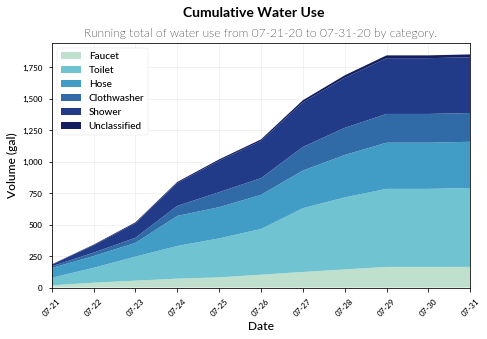

In [16]:
# Creates copy of dataframe
stack_per = class_tot_cumsum.copy()

# Main plot options
style = 'seaborn-paper'
size = (7.5, 5)
figtype = 'png'

# Time period and label category
period = 'Month' # Year, Month, Week, or Day
period_show = 'Complete'  # Complete or Daily
category_key = 'No_Irrigation' # All, Indoor, Outdoor, No_Unclassified, No_Irrigation, or No_Irrigation_Unclassified
category = labDict[category_key] # Uses labels dictionary to choose what to show

# Time selection (Only need to select date periods for chosen temporal scale)
year = 2020
month = 7
week = 30
day = 1

# Automatically Chooses Y-Axis Column
if period_show == 'Daily':
    y_col = 'Volume(gal)_Day'
elif period == 'Year':
    y_col = 'Volume(gal)_Year'
elif period == 'Month':
    y_col = 'Volume(gal)_Month'
elif period == 'Week':
    y_col = 'Volume(gal)_Week'
elif period == 'Day':
    y_col = 'Volume(gal)_Day'
    
# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots()
fig.set_size_inches(size)

# Colors selected based on number of labels
custom_cycler = color_palette_cycler(category)
ax.set_prop_cycle(custom_cycler)

# Chooses data based on labels and time period
if period == 'Year':
    x = stack_per.loc[pd.IndexSlice[category[0], year, :, :, :], 'Date']
    y = []
    for label in category:
        sel = stack_per.loc[pd.IndexSlice[label, year, :, :, :], y_col]
        y.append(sel)
elif period == 'Month':
    x = stack_per.loc[pd.IndexSlice[category[0], year, month, :, :], 'Date']
    y = []
    for label in category:
        sel = stack_per.loc[pd.IndexSlice[label, year, month, :, :], y_col]
        y.append(sel)
elif period == 'Week':
    x = stack_per.loc[pd.IndexSlice[category[0], year, month, week, :], 'Date']
    y = []
    for label in category:
        sel = stack_per.loc[pd.IndexSlice[label, year, month, week, :], y_col]
        y.append(sel)
elif period == 'Day':
    x = stack_per.loc[pd.IndexSlice[category[0], year, month, week, day], 'Date']
    y = []
    for label in category:
        sel = stack_per.loc[pd.IndexSlice[label, year, month, week, day], y_col]
        y.append(sel)

# Creates plot
ax.stackplot(x, y)

# Formats ticks of x axis
base_major = 1.0 # Sets spacing of major tick marks
base_minor = 1.0 # Sets spacing of minor tick marks
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base_major))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=base_minor))
ax.tick_params(which='minor', length=2, width=1)
ax.margins(x=0, y=0.05)
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='center')

# Formats ticks of y axis
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))

# Creates grid markers
ax.set_axisbelow(True)
ax.grid(which='both', alpha=0.2)

# Formats legend
category = [category[category.index(x)].title() for x in category] # Capitalizes labels
font_leg = fm.FontProperties(family=font_legend, weight=fontweight_legend, size=fontsize_legend)
ax.legend(category, loc='upper left', frameon=True, framealpha=1, prop=font_leg)

# Formats the font of tick mark labels
for tick in ax.get_xticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)
for tick in ax.get_yticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)

# Creates subtitle for chart
if period_show == 'Daily':
    sub_title = 'Daily water use from ' + \
        min(x).strftime('%m-%d-%y') + ' to ' + \
        max(x).strftime('%m-%d-%y') + ' by category.'
elif period_show == 'Complete':
    sub_title = 'Running total of water use from ' + \
        min(x).strftime('%m-%d-%y') + ' to ' + \
        max(x).strftime('%m-%d-%y') + ' by category.'
# Sets axis and chart titles
ax.set_xlabel("Date", fontsize=fontsize_axis, fontname=font_axis, fontweight=fontweight_axis)
ax.set_ylabel("Volume (gal)", fontsize=fontsize_axis, fontname=font_axis, fontweight=fontweight_axis)
fig.suptitle('Cumulative Water Use', fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig)
ax.set_title(sub_title, fontsize=fontsize_title, fontname=font_title, fontweight=fontweight_title)

# Creates a file name and saves the chart
period = period[:1]
period_show = period_show[:1]
figname = 'Stack'+'_'+period+period_show+'_'+category_key+'_'+min(x).strftime('%m-%d')+'_'+'to'+'_'+max(x).strftime('%m-%d')+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches=0, transparent=False)

Selectable by date range.

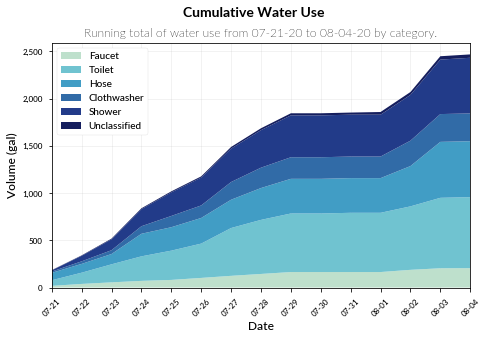

In [17]:
# Creates copy of dataframe
stack_range = class_tot_cumsum.copy()
stack_range.reset_index(inplace=True)

# Main plot options
style = 'seaborn-paper'
size = (7.5, 5)
figtype = 'png'

# Time period and label category
period = 'Year' # Year, Month, Week, or Day
period_show = 'Complete'  # Complete or Daily
category_key = 'No_Irrigation' # All, Indoor, Outdoor, No_Unclassified, No_Irrigation, or No_Irrigation_Unclassified
category = labDict[category_key] # Uses labels dictionary to choose what to show

# Date range selection
start = '2020-07-21'
end = '2020-08-04'
start_time = dt.strptime(start, '%Y-%m-%d')
end_time = dt.strptime(end, '%Y-%m-%d')

# Automatically Chooses Y-Axis Column
if period_show == 'Daily':
    y_col = 'Volume(gal)_Day'
elif period == 'Year':
    y_col = 'Volume(gal)_Year'
elif period == 'Month':
    y_col = 'Volume(gal)_Month'
elif period == 'Week':
    y_col = 'Volume(gal)_Week'
elif period == 'Day':
    y_col = 'Volume(gal)_Day'

# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots()
fig.set_size_inches(size)

# Colors selected based on number of labels
custom_cycler = color_palette_cycler(category)
ax.set_prop_cycle(custom_cycler)

# Chooses data based on labels and date range
mask = (stack_range['Date'] >= start_time) & (stack_range['Date'] <= end_time) & (stack_range['Label'] == category[0])
x = stack_range.loc[mask, 'Date']
y = []
for label in category:
    mask = (stack_range['Date'] >= start_time) & (stack_range['Date'] <= end_time) & (stack_range['Label'] == label)
    sel = stack_range.loc[mask, y_col]
    y.append(sel)

# Creates plot
ax.stackplot(x, y)

# Formats ticks of x axis
base_major = 1.0 # Sets spacing of major tick marks
base_minor = 1.0 # Sets spacing of minor tick marks
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base_major))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=base_minor))
ax.tick_params(which='minor', length=2, width=1)
ax.margins(x=0, y=0.05)
fig.autofmt_xdate(bottom=0.2, rotation=45, ha='center')

# Formats ticks of y axis
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))

# Creates grid markers
ax.set_axisbelow(True)
ax.grid(which='both', alpha=0.2)

# Formats legend
category = [category[category.index(x)].title() for x in category] # Capitalizes labels
font_leg = fm.FontProperties(family=font_legend, weight=fontweight_legend, size=fontsize_legend)
ax.legend(category, loc='upper left',frameon=True, framealpha=1, prop=font_leg)

# Formats the font of tick mark labels
for tick in ax.get_xticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)
for tick in ax.get_yticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)

# Creates subtitle for chart
if period_show == 'Daily':
    sub_title = 'Daily water use from ' + \
        min(x).strftime('%m-%d-%y') + ' to ' + \
        max(x).strftime('%m-%d-%y') + ' by category.'
elif period_show == 'Complete':
    sub_title = 'Running total of water use from ' + \
        min(x).strftime('%m-%d-%y') + ' to ' + \
        max(x).strftime('%m-%d-%y') + ' by category.'

# Sets axis and chart titles
ax.set_xlabel("Date", fontsize=fontsize_axis, fontname=font_axis, fontweight=fontweight_axis)
ax.set_ylabel("Volume (gal)", fontsize=fontsize_axis, fontname=font_axis, fontweight=fontweight_axis)
fig.suptitle('Cumulative Water Use', fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig)
ax.set_title(sub_title, fontsize=fontsize_title,fontname=font_title, fontweight=fontweight_title)

# Creates a file name and saves the chart
period = period[:1]
period_show = period_show[:1]
figname = 'Stack'+'_'+period+period_show+'_'+category_key+'_'+ \
    min(x).strftime('%m-%d')+'_'+'to'+'_'+max(x).strftime('%m-%d')+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches=0, transparent=False)

### Bar Plot Averages
Select by date range.

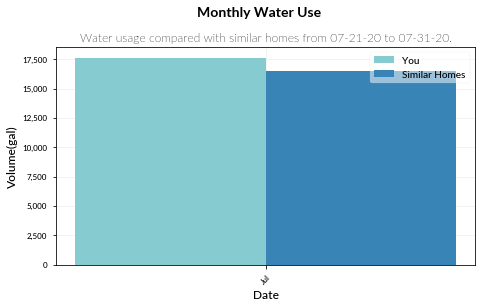

In [31]:
# Main plot options
style = 'seaborn-paper'
figtype = 'png'
size = (7.5, 4)
width = 0.8 # Controls relative width of bars

# Date range selection (must contain minimum and maximum dates of desired period)
period = 'Month' # Year, Month, Week, or Day (chooses period to show per bar)
start = '2020-07-21'
end = '2020-07-31'
start_time = dt.strptime(start, '%Y-%m-%d')
end_time = dt.strptime(end, '%Y-%m-%d')

# Automatically chooses dataframe for bar plot
if period == 'Day':
    bar_plot = day_total
elif period == 'Week':
    bar_plot = week_total
elif period == 'Month':
    bar_plot = month_total
elif period == 'Year':
    bar_plot = year_total

# Selects portion of dataframe for given date range
if period == 'Day':
    bar_plot = bar_plot.loc[(bar_plot['Date'] >= start_time) & (bar_plot['Date'] <= end_time)]
else:
    bar_plot = bar_plot.loc[(bar_plot['Date_min'] >= start_time) & (bar_plot['Date_max'] <= end_time)]

# Sets name used in title
if period == 'Day':
    period_name = 'Daily'
elif period == 'Week':
    period_name = 'Weekly'
elif period == 'Month':
    period_name = 'Monthly'
elif period == 'Year':
    period_name = 'Yearly'

# Sets data range to display in subtitle
if period == 'Day':
    x_title = bar_plot['Date']
else:
    x_title_min = bar_plot['Date_min']
    x_title_max = bar_plot['Date_max']

# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots()
fig.set_size_inches(size)

# Selects data for x axis
x = np.arange(len(bar_plot['Date_label']))
ax.bar(x - width/4, bar_plot['Volume(gal)_Day'], color='#85CBCF', width=width/2, label='You')
ax.bar(x + width/4, bar_plot['Expected'], color='#3984B6', width=width/2, label='Similar Homes')

# Formats the font of y axis tick mark labels
for tick in ax.get_yticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)

# Formats the x axis tick mark labels
ax.set_xticks(x)
ax.set_xticklabels(bar_plot['Date_label'], fontname=font_tick, fontweight=fontweight_tick, rotation=45)
 
# Formats ticks of y axis
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
    
# Creates title for chart
title = period_name + ' Water Use'

# Creates subtitle for chart
if period == 'Day':
    sub_title = 'Water usage compared with similar homes from ' + \
        min(x_title).strftime('%m-%d-%y') + ' to ' + \
        max(x_title).strftime('%m-%d-%y') + '.'
else:
    sub_title = 'Water usage compared with similar homes from ' + \
        min(x_title_min).strftime('%m-%d-%y') + ' to ' + \
        max(x_title_max).strftime('%m-%d-%y') + '.'

# Sets axis and chart titles
ax.set_xlabel('Date', fontsize=fontsize_axis, fontname=font_axis, fontweight=fontweight_axis)
ax.set_ylabel('Volume(gal)', fontsize=fontsize_axis, fontname=font_axis, fontweight=fontweight_axis)
fig.suptitle(title, fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig, y=1.02)
ax.set_title(sub_title, fontsize=fontsize_title, fontname=font_title, fontweight=fontweight_title)

# Creates grid markers
ax.set_axisbelow(True)
ax.grid(which='both', alpha=0.2)

# Formats legend
font_leg = fm.FontProperties(family=font_legend, weight=fontweight_legend, size=fontsize_legend)
ax.legend(prop=font_leg, framealpha=0.5, fancybox=True)

# Creates a file name and saves the chart
if period == 'Day':
    period = period[:1]
    figname = 'Averages_'+period+'_'+min(x_title).strftime('%m-%d')+'_'+'to'+'_' + \
        max(x_title).strftime('%m-%d')+'.'+figtype
else:
    period = period[:1]
    figname = 'Averages_'+period+'_'+min(x_title_min).strftime('%m-%d')+'_'+'to'+'_'+max(
        x_title_max).strftime('%m-%d')+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches='tight', transparent=False)

### Pulses Plot

Adds labels to raw data if existing in classified data.

In [19]:
# Day to show
day = '2020-07-26'

# Selects portion of raw data for selected day
pulses_plot = raw_orig.loc[day : day].reset_index() # Selects portion of raw data
pulses_plot = pulses_plot.drop(pulses_plot.loc[pulses_plot['Pulses']==0].index) # Drops all values of zeros
pulses_plot['Label'] = 'unclassified' # Sets default label to unclassified for later classification

# Labels the raw data if it exists within the classified data
for i in class_orig.index:
    start = datetime.datetime.strptime(class_orig.at[i,'StartTime'],"%Y-%m-%d %H:%M:%S")
    end = datetime.datetime.strptime(class_orig.at[i,'EndTime'],"%Y-%m-%d %H:%M:%S")
    for j in pulses_plot.index:
        if start <= pulses_plot.at[j,'Time'] <= end:
            pulses_plot.at[j,'Label'] = class_orig.at[i,'Label']
        else:
            pass

# Regroups data by label and drops remaining unclassified data
pulses_plot = pulses_plot.drop(pulses_plot.loc[pulses_plot['Label']=='unclassified'].index)
pulses_plot = pulses_plot.groupby('Label')

Plots the labeled raw data as an example of how data are classified.

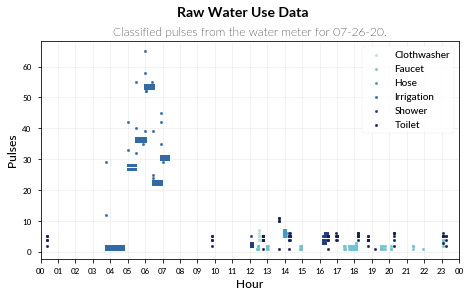

In [20]:
# Main plot options
size = (7.5,4)
style = 'seaborn-paper'

# Creates bbject for plot
plt.style.use(style)
fig, ax = plt.subplots()
fig.set_size_inches(size)

# Chooses color palette based on labels in the data
labels_plot = pulses_plot['Label'].unique()
custom_cycler = color_palette_cycler(labels_plot)
ax.set_prop_cycle(custom_cycler)

# Creates a scatter plot of pulses by adding each label in a loop
for name, group in pulses_plot:
    ax.scatter(group['Time'], group['Pulses'], label=name.capitalize(), s=7, marker='o')

# Sets tick marks for x axis and formats to show only hours
ax.set_xlim(pd.to_datetime(day),pd.to_datetime(day)+pd.DateOffset(1))
hours = mdates.HourLocator()
h_fmt = mdates.DateFormatter('%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt) 

# Formats the font of tick mark labels
for tick in ax.get_xticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)
for tick in ax.get_yticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)

#Formats the date string for the subtitle and filename
day_title = dt.strptime(day, '%Y-%m-%d')
day_title = day_title.strftime('%m-%d-%y')
day_file = dt.strptime(day, '%Y-%m-%d')
day_file = day_file.strftime('%m-%d')

# Sets axis and chart titles
fig.suptitle('Raw Water Use Data', fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig, y=1)
subtitle = 'Classified pulses from the water meter for ' + day_title + '.'
ax.set_title(subtitle, fontsize=fontsize_title, fontname=font_title, fontweight=fontweight_title)
ax.set_xlabel('Hour', fontsize = fontsize_axis, fontname=font_axis, fontweight =fontweight_axis)
ax.set_ylabel('Pulses', fontsize = fontsize_axis, fontname=font_axis, fontweight =fontweight_axis)

# Creates grid markers
ax.set_axisbelow(True)
ax.grid(which='both', alpha=0.2)

# Formats legend
font_leg = fm.FontProperties(family=font_legend, weight=fontweight_legend, size=fontsize_legend)
ax.legend(prop=font_leg)

# Creates a file name and saves the chart
figname = 'Pulses_'+day_file+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches='tight', transparent=False)

### Swarm Plot
Select by date range. Used to visualize distribution of individual events.

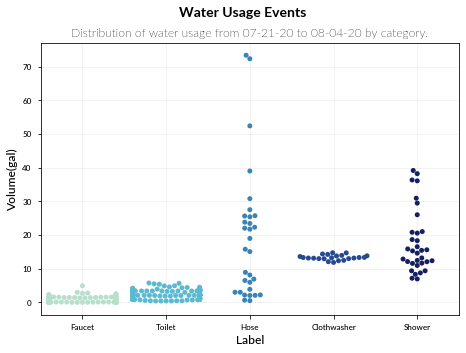

In [21]:
# Creates copy of dataframe
swarm_plot = class_orig.copy()

# Main plot options
style = 'seaborn-paper'
size = (7.5,5)
figtype = 'png'

# Label category
category_key = 'No_Irrigation_Unclassified' # All, Indoor, Outdoor, No_Unclassified, No_Irrigation, or No_Irrigation_Unclassified
category = labDict[category_key] # Uses category dictionary to choose what to show

# Date range selection
start = '2020-07-21'
end = '2020-08-04'

# Selects portion of dataframe based on date range
swarm_plot['StartTime'] = pd.to_datetime(swarm_plot['StartTime'], format='%Y-%m-%d %H:%M:%S')
swarm_plot.set_index('StartTime', inplace=True)
swarm_plot.sort_index(inplace=True)
swarm_plot = swarm_plot.loc[start : end].reset_index()

# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots()
fig.set_size_inches(size)

# Colors selected based on number of labels
sns.set_palette(sns.color_palette(color_palette(category)))

# Sets title for axis labels
x_label = 'Label'
y_label = 'Volume(gal)'

# Creates swarmplot
ax = sns.swarmplot(x=x_label, y=y_label, order=category, data=swarm_plot)

# Capitalizes tick labels in x axis
labels = [label.capitalize() for label in category]
ax.set_xticklabels(labels)

# Formats the font of tick mark labels
for tick in ax.get_xticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)
for tick in ax.get_yticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)

# Formats ticks of y axis
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
    
# Formats axis labels
ax.set_xlabel(x_label, fontsize = fontsize_axis, fontname=font_axis, fontweight =fontweight_axis)
ax.set_ylabel(y_label, fontsize = fontsize_axis, fontname=font_axis, fontweight =fontweight_axis)

# Creates grid markers
ax.set_axisbelow(True)
ax.grid(which='both', alpha=0.2)

# Sets chart title and subtitle
fig.suptitle('Water Usage Events', fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig)
start_title = dt.strptime(start, '%Y-%m-%d')
start_title = start_title.strftime('%m-%d-%y')
end_title = dt.strptime(end, '%Y-%m-%d')
end_title = end_title.strftime('%m-%d-%y')
sub_title = 'Distribution of water usage from ' + start_title + ' to ' + end_title + ' by category.'
ax.set_title(sub_title, fontsize=fontsize_title,fontname=font_title, fontweight=fontweight_title)

# Creates a file name and saves the chart
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Swarm_'+category_key+'_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches='tight', transparent=False)

### Multiple Bar Plots

Vertical

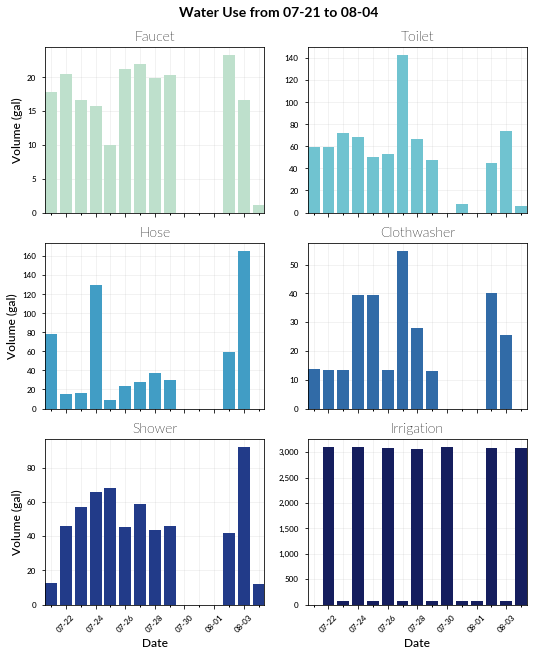

In [22]:
# Creates copy of dataframe
scatter_mult = class_tot_cumsum.copy()
scatter_mult.reset_index(inplace=True)

# Main plot options
style = 'seaborn-paper'
size = (7.5,10)
figtype = 'png'
category_key = 'No_Unclassified'
category = labDict[category_key]

# Creates array of colors based on labels
colors = color_palette(category)

# Date range selection
start = '2020-07-21'
end = '2020-08-04'
start_time = dt.strptime(start, '%Y-%m-%d')
end_time = dt.strptime(end, '%Y-%m-%d')

# Date range selection of dataframe
scatter_mult = scatter_mult.loc[(scatter_mult['Date'] >= start_time) & (scatter_mult['Date'] <= end_time)]

# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots(3,2)
fig.set_size_inches(size)

fig.tight_layout(pad=1.5)

# Sets title for each of the plots
x = -1
y = 1
for label in category:
    if y == 1:
        x = x + 1
    y = (y + 1) % 2
    ax[x,y].set_title(label.title(), fontsize=fontsize_title_mult,fontname=font_title_mult, fontweight=fontweight_title_mult)

# Plots data
x = -1
y = 1
count = 0
for label in category:
    color = colors[count]
    count = count + 1
    if y == 1:
        x = x + 1
    y = (y + 1) % 2
    mask = scatter_mult['Label'] == label
    x_val = scatter_mult.loc[mask, 'Date']
    y_val = scatter_mult.loc[mask, 'Volume(gal)_Day']
    ax[x,y].bar(x_val, y_val, color=color)

# Set axis labels
for y in range(3): 
    ax[y,0].set_ylabel('Volume (gal)', fontsize = fontsize_axis_mult, fontname=font_axis_mult, fontweight =fontweight_axis_mult)
for x in range(2):
    ax[2,x].set_xlabel('Date', fontsize = fontsize_axis_mult, fontname=font_axis_mult, fontweight =fontweight_axis_mult)

# Spacing of major and minor tick marks on x axis
base_major = 2.0
base_minor = 1.0
    
# Formats ticks of x axis
for axe in ax.flat:
    axe.xaxis.set_major_formatter(DateFormatter("%m-%d"))
    axe.xaxis.set_major_locator(ticker.MultipleLocator(base=base_major))
    axe.xaxis.set_minor_locator(ticker.MultipleLocator(base=base_minor))
    axe.tick_params(which='minor', length=1.5, width=1)
    axe.margins(x=0,y=0.05)
    fig.autofmt_xdate(bottom=0.2, rotation=45, ha='center')

# Formats ticks of y axis
for axe in ax.flat:
    axe.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
    
# Formats the font of tick mark labels
for axe in ax.flat:
    for tick in axe.get_xticklabels():
        tick.set_fontname(font_tick_mult)
        tick.set_fontweight(fontweight_tick_mult)
    for tick in axe.get_yticklabels():
        tick.set_fontname(font_tick_mult)
        tick.set_fontweight(fontweight_tick_mult)    

# Creates grid markers
for axe in ax.flat:
    axe.set_axisbelow(True)
    axe.grid(which='both', alpha=0.2)

# Add and format plot figure title
start_title = dt.strptime(start, '%Y-%m-%d')
start_title = start_title.strftime('%m-%d')
end_title = dt.strptime(end, '%Y-%m-%d')
end_title = end_title.strftime('%m-%d')
title = 'Water Use from ' + start_title + ' to ' + end_title
fig.suptitle(title, fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig, y=1.03)

# Creates a file name and saves the chart
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Multiple_Vert_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches='tight', transparent=False)

Horizontal

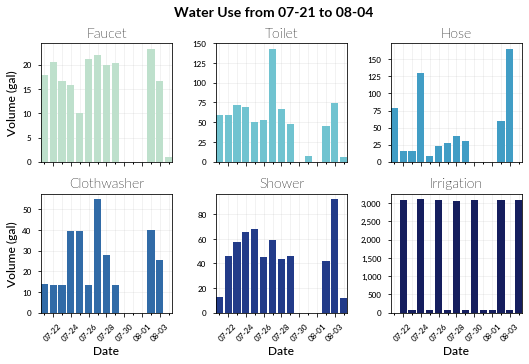

In [23]:
# Creates copy of dataframe
scatter_mult = class_tot_cumsum.copy()
scatter_mult.reset_index(inplace=True)

# Main plot options
style = 'seaborn-paper'
size = (7.5,5)
figtype = 'png'
category_key = 'No_Unclassified'
category = labDict[category_key]

# Creates array of colors based on labels
colors = color_palette(category)

# Date range selection
start = '2020-07-21'
end = '2020-08-04'
start_time = dt.strptime(start, '%Y-%m-%d')
end_time = dt.strptime(end, '%Y-%m-%d')

# Date range selection of dataframe
scatter_mult = scatter_mult.loc[(scatter_mult['Date'] >= start_time) & (scatter_mult['Date'] <= end_time)]

# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots(2,3)
fig.set_size_inches(size)

fig.tight_layout(pad=1.5)

# Sets title for each of the plots
x = 0
y = -1
for label in category:
    y = y + 1
    if y == 3:
        y = 0
        x = x + 1
    ax[x,y].set_title(label.title(), fontsize=fontsize_title_mult,fontname=font_title_mult, fontweight=fontweight_title_mult)
    
# Plots data
x = 0
y = -1
count = 0
for label in category:
    color = colors[count]
    count = count + 1
    y = y + 1
    if y == 3:
        y = 0
        x = x + 1
    mask = scatter_mult['Label'] == label
    x_val = scatter_mult.loc[mask, 'Date']
    y_val = scatter_mult.loc[mask, 'Volume(gal)_Day']
    ax[x,y].bar(x_val, y_val, color=color)

# Set axis labels
for y in range(2): 
    ax[y,0].set_ylabel('Volume (gal)', fontsize = fontsize_axis_mult, fontname=font_axis_mult, fontweight =fontweight_axis_mult)
for x in range(3):
    ax[1,x].set_xlabel('Date', fontsize = fontsize_axis_mult, fontname=font_axis_mult, fontweight =fontweight_axis_mult)

# Spacing of major and minor tick marks on x axis
base_major = 2.0
base_minor = 1.0
    
# Formats ticks of x axis
for axe in ax.flat:
    axe.xaxis.set_major_formatter(DateFormatter("%m-%d"))
    axe.xaxis.set_major_locator(ticker.MultipleLocator(base=base_major))
    axe.xaxis.set_minor_locator(ticker.MultipleLocator(base=base_minor))
    axe.tick_params(which='minor', length=1.5, width=1)
    axe.margins(x=0,y=0.05)
    fig.autofmt_xdate(bottom=0.2, rotation=45, ha='center')

# Formats ticks of y axis
for axe in ax.flat:
    axe.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
    
# Formats the font of tick mark labels
for axe in ax.flat:
    for tick in axe.get_xticklabels():
        tick.set_fontname(font_tick_mult)
        tick.set_fontweight(fontweight_tick_mult)
    for tick in axe.get_yticklabels():
        tick.set_fontname(font_tick_mult)
        tick.set_fontweight(fontweight_tick_mult)    

# Creates grid markers
for axe in ax.flat:
    axe.set_axisbelow(True)
    axe.grid(which='both', alpha=0.2)

# Add and format plot figure title
start_title = dt.strptime(start, '%Y-%m-%d')
start_title = start_title.strftime('%m-%d')
end_title = dt.strptime(end, '%Y-%m-%d')
end_title = end_title.strftime('%m-%d')
title = 'Water Use from ' + start_title + ' to ' + end_title
fig.suptitle(title, fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig, y=1.05)

# Creates a file name and saves the chart
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Multiple_Hor_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches='tight', transparent=False)

### Summary Table
Generates a quick table to show totals by category.

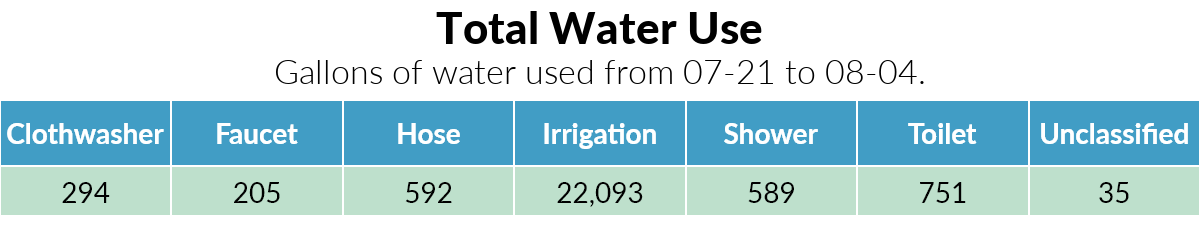

In [24]:
# Creates copy of dataframe
sum_table = class_tot_cumsum.copy()
sum_table.reset_index(inplace=True)
sum_table['Label'] = sum_table['Label'].str.title() 

# Main plot options
figtype = 'png'

# Date range selection
start = '2020-07-21'
end = '2020-08-04'
start_time = dt.strptime(start, '%Y-%m-%d')
end_time = dt.strptime(end, '%Y-%m-%d')

# Date range selection of dataframe
sum_table = sum_table.loc[(sum_table['Date'] >= start_time) & (sum_table['Date'] <= end_time)]

# Formats volume column
sum_table = sum_table.groupby(by='Label')[['Volume(gal)_Day']].sum()
sum_table['Volume(gal)_Day'] = sum_table['Volume(gal)_Day'].astype(int)
sum_table['Volume(gal)_Day'] = sum_table['Volume(gal)_Day'].map('{:,}'.format)
sum_table['Volume(gal)_Day'] = sum_table['Volume(gal)_Day'].astype(str)

# Transpose table
sum_table = sum_table.T

# Creates bolded headers according to html formatting
headers = list(sum_table.columns)
bold = '<b>'
for item in range(len(headers)):
    position = item - 1
    headers[position] = bold + headers[position] + bold
    
# Creates plotly table
fig = go.Figure(layout_margin=dict(t=0, b=0, r=0, l=0), data=[go.Table(
    header=dict(values=headers,
                fill_color='#419DC5',
                align='center',
                font=dict(color='white', size=14, family=font_fig),
                height = 26
               ),
    cells=dict(values=[sum_table.Clothwasher, sum_table.Faucet, sum_table.Hose, sum_table.Irrigation, sum_table.Shower, sum_table.Toilet, sum_table.Unclassified],
               fill_color='#BEE0CC',
               align='center',
               font=dict(color='black', size=14, family=font_fig),
               height=25
              ))
])

# Display image to be able to save
img_bytes = fig.to_image(format="png", width=600, height=500, scale=2)

# Converts bytes array to Pillow image
sum_table_img = Image.open(io.BytesIO(img_bytes))
width, height = sum_table_img.size 

# Setting the points for cropped image 
left = 0
top = -100
right = width
bottom = height/8

# Crops the image
sum_table_img_crop = sum_table_img.crop((left, top, right, bottom))

# Creates a file name and saves the image
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Table_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
sum_table_img_save = sum_table_img_crop.save(figpath)

# Reload image path
sum_table_img = Image.open(figpath)

# Create object for writing on image
draw = ImageDraw.Draw(sum_table_img)

# Use a truetype fond
font1 = ImageFont.truetype('Fonts\Lato-Heavy.ttf', 44)
font2 = ImageFont.truetype('Fonts\Lato-Light.ttf', 34)

# Set title and subtitle strings
start_title = dt.strptime(start, '%Y-%m-%d')
start_title = start_title.strftime('%m-%d')
end_title = dt.strptime(end, '%Y-%m-%d')
end_title = end_title.strftime('%m-%d')
title = 'Total Water Use'
subtitle = 'Gallons of water used from ' + start_title + ' to ' + end_title + '.'

# Write shower text on image
w, h = draw.textsize(title, font1) # Calculate width to center text
draw.text((600-w/2, 0), title, font=font1, fill=(0,0,0,255))
w, h = draw.textsize(subtitle, font2) # Calculate width to center text
draw.text((600-w/2, 50), subtitle, font=font2, fill=(0,0,0,255))

# Display image in notebook
display(sum_table_img)

# Creates a file name and saves the image
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Table_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
sum_table_img.save(figpath)

### Infographic Equivalent Usage

Calculates the equivalent water usage for the selected period.

In [25]:
# Select a date range of raw data for totals
start = '2020-07-21'
end = '2020-07-26'
infographic_plot = raw_orig.loc[start : end].reset_index()

# Convert date range to string for title
start_title = dt.strptime(start, '%Y-%m-%d')
start_title = start_title.strftime('%m-%d')
end_title = dt.strptime(end, '%Y-%m-%d')
end_title = end_title.strftime('%m-%d')

# Finds total water used in period
total_water = infographic_plot['Volume(gal)'].sum()

# Finds total number of water bottles (standard 16.9oz size)
bottle = 16.9/128
total_bottles = format(int(round(total_water/bottle, 0)),',')

# Finds total number of showers (average 5min shower at 2.5 gpm)
shower = 2.5 * 5
total_showers = str(format(int(round(total_water/shower, 0)),','))

# Finds total number of toilet flushes (for an older 5gal toilet)
toilet = 5
total_toilets = format(int(round(total_water/toilet, 0)),',')

Adds the date range and equivalent water usage to a graphic template.

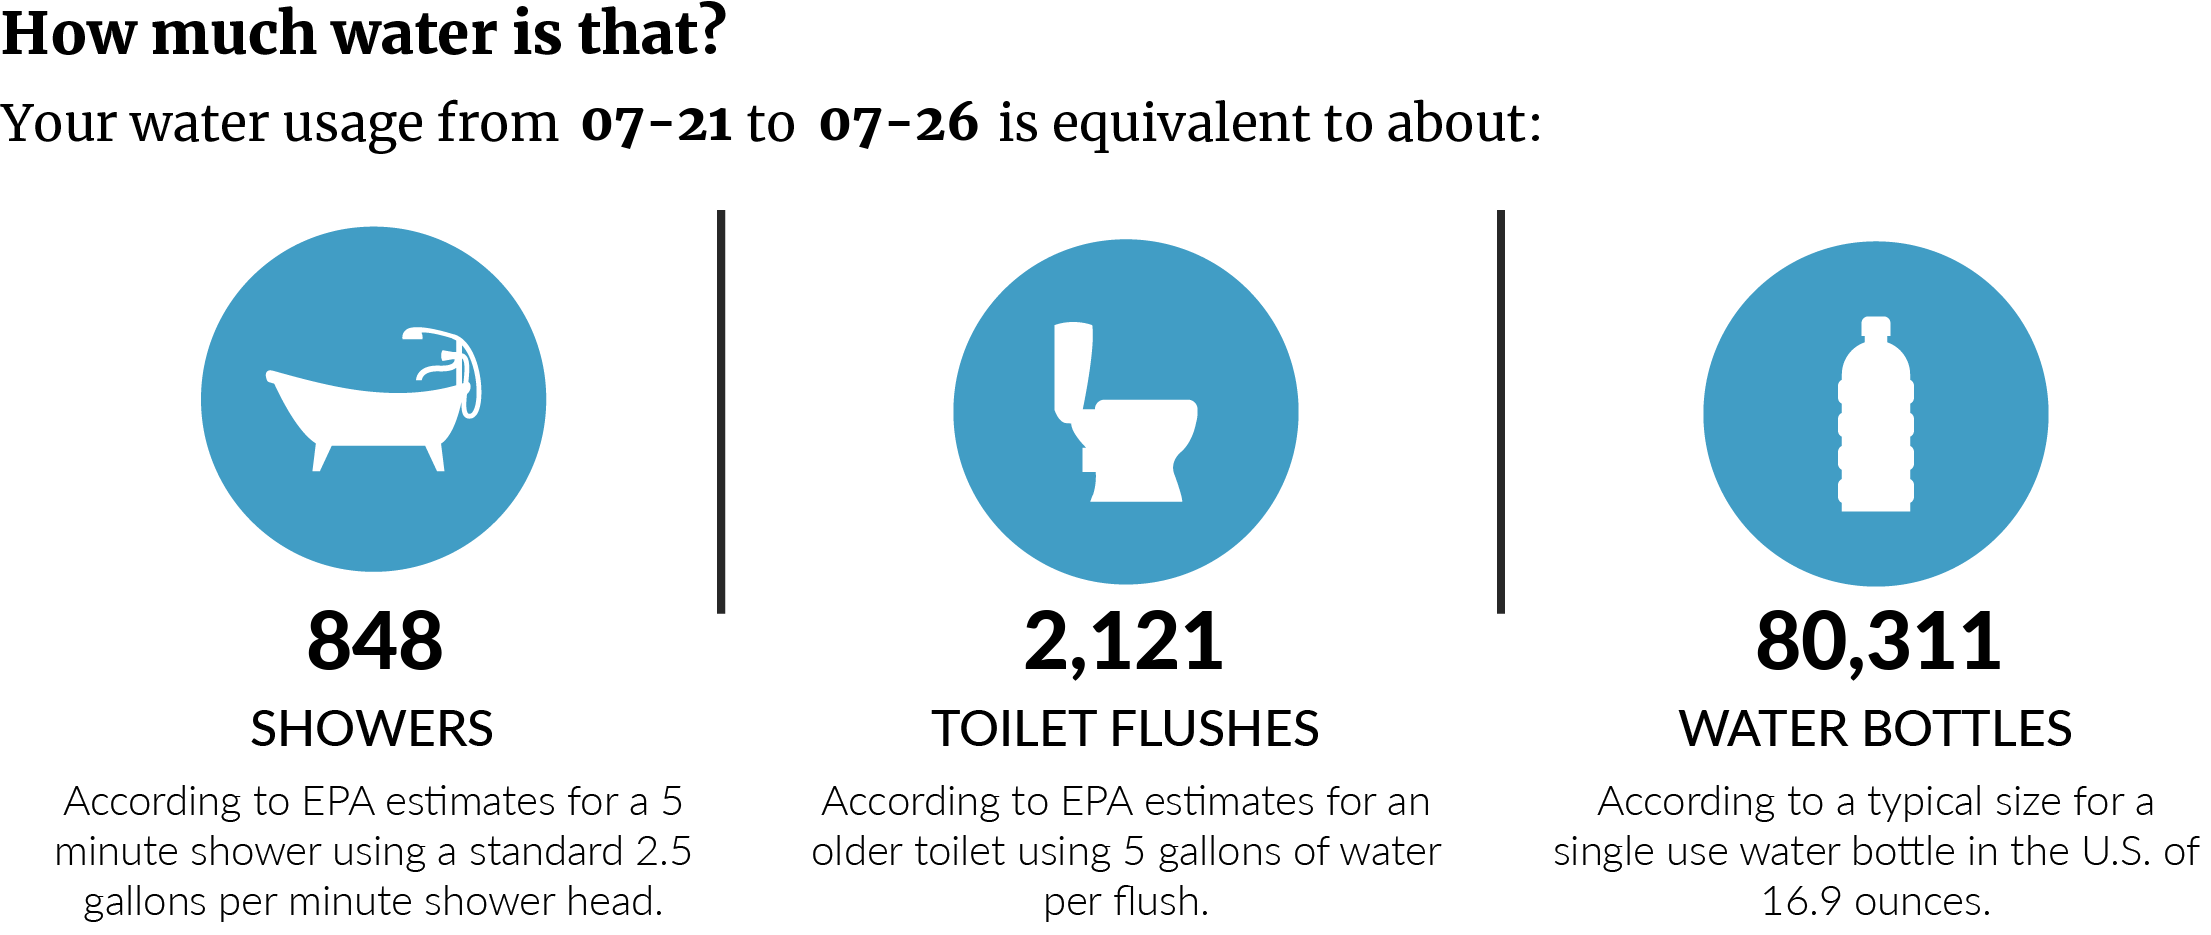

In [26]:
# Load image path
infographic_empty = Image.open('Graphics\Infographic_Empty.png')

# Create object for writing on image
draw = ImageDraw.Draw(infographic_empty)

# Use a truetype fond
font1 = ImageFont.truetype('Fonts\Lato-Heavy.ttf', 80)
font2 = ImageFont.truetype('Fonts\Merriweather-Black.ttf', 51)

# Write date text on image
draw.text((580, 90), start_title, font=font2, fill=(0,0,0,255))
draw.text((818, 90), end_title, font=font2, fill=(0,0,0,255))

# Write shower text on image
w, h = draw.textsize(total_showers, font1) # Calculate width to center text
draw.text((375-w/2, 590), total_showers, font=font1, fill=(0,0,0,255))

# Write toilet text on image
w, h = draw.textsize(total_toilets, font1) # Calculate width to center text
draw.text((1125-w/2, 590), total_toilets, font=font1, fill=(0,0,0,255))

# Write bottle text on image
w, h = draw.textsize(total_bottles, font1) # Calculate width to center text
draw.text((1880-w/2, 590), total_bottles, font=font1, fill=(0,0,0,255))

# Display image in notebook
display(infographic_empty)

# Creates a file name and saves the image
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Infographic_Complete_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
infographic_empty.save(figpath)

### Usage and Time of Day
Creates a lineplot for the average water use for each hour of the day.

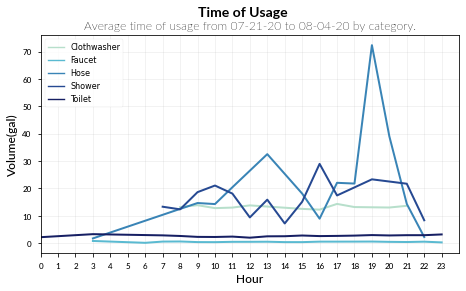

In [28]:
# Creates copy of dataframe
time_use = class_orig.copy()

# Main plot options
style = 'seaborn-paper'
size = (7.5,4)
figtype = 'png'

# Label category
category_key = 'No_Irrigation_Unclassified' # All, Indoor, Outdoor, No_Unclassified, No_Irrigation, or No_Irrigation_Unclassified
category = labDict[category_key] # Uses category dictionary to choose what to show

# Find value to drop based on category selection
category_all = labDict['All']
category_remove = list((Counter(category_all)-Counter(category)).elements()) 

for label in category_remove:
    time_use = time_use[time_use.Label != label]

# Get all labels from dataframe
Labels_uniq = time_use.Label.unique()

# Date range selection
start = '2020-07-21'
end = '2020-08-04'

# Selects portion of dataframe based on date range
time_use['StartTime'] = pd.to_datetime(time_use['StartTime'], format='%Y-%m-%d %H:%M:%S')
time_use.set_index('StartTime', inplace=True)
time_use.sort_index(inplace=True)
time_use = time_use.loc[start : end].reset_index()

# Date range selection of dataframe
time_use = time_use.loc[(time_use['StartTime'] >= start_time) & (time_use['StartTime'] <= end_time)]

# Set datetime index
time_use.set_index('StartTime', inplace=True)
time_use.sort_index(inplace=True)

# Group values by label and hour and find averages
time_use = time_use.groupby(by=['Label',time_use.index.hour])[['Volume(gal)']].mean()
time_use = time_use.rename_axis(index=['Label','Hour'])

# Reset index for later calculations
time_use.reset_index(inplace=True)

# Creates list of hours
hours = [i for i in range(24)]

# Capitalizes all labels
time_use['Label'] = time_use['Label'].str.title()

# Resorts index
time_use = time_use.set_index(['Label', 'Hour']).sort_index()
time_use.reset_index(inplace=True)

# Convert volume to float
time_use['Volume(gal)'] = time_use['Volume(gal)'].astype(float)

# Creates object for plot
plt.style.use(style)
fig, ax = plt.subplots()
fig.set_size_inches(size)

# Colors selected based on number of labels
sns.set_palette(sns.color_palette(color_palette(category)))

# Creates plot
ax = sns.lineplot(data=time_use, x="Hour", y="Volume(gal)", hue="Label", linewidth = 2)

# Formats axis labels
x_label = 'Hour'
y_label = 'Volume(gal)'
ax.set_xlabel(x_label, fontsize = fontsize_axis, fontname=font_axis, fontweight =fontweight_axis)
ax.set_ylabel(y_label, fontsize = fontsize_axis, fontname=font_axis, fontweight =fontweight_axis)

# Formats the font of tick mark labels
for tick in ax.get_xticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)
for tick in ax.get_yticklabels():
    tick.set_fontname(font_tick)
    tick.set_fontweight(fontweight_tick)

# Formats ticks of y axis
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))

# Removes legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

# Set x axis ticks and respective labels
ax.set_xlim(0, 24)
ax.xaxis.set_ticks(np.arange(0, 24, 1))

# Creates grid markers
ax.set_axisbelow(True)
ax.grid(which='both', alpha=0.2)

# Sets chart title and subtitle
fig.suptitle('Time of Usage', fontsize=fontsize_fig, fontname=font_fig, fontweight=fontweight_fig)
start_title = dt.strptime(start, '%Y-%m-%d')
start_title = start_title.strftime('%m-%d-%y')
end_title = dt.strptime(end, '%Y-%m-%d')
end_title = end_title.strftime('%m-%d-%y')
sub_title = 'Average time of usage from ' + start_title + ' to ' + end_title + ' by category.'
ax.set_title(sub_title, fontsize=fontsize_title,fontname=font_title, fontweight=fontweight_title)

# Creates a file name and saves the chart
start_file = dt.strptime(start, '%Y-%m-%d')
start_file = start_file.strftime('%m-%d')
end_file = dt.strptime(end, '%Y-%m-%d')
end_file = end_file.strftime('%m-%d')
figname = 'Hourly_Use_'+category_key+'_'+start_file+'_to_'+end_file+'.'+figtype
figpath = os.path.join(Results, figname)
fig.savefig(figpath, dpi=300, bbox_inches='tight', transparent=False)